In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


In [45]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [20, 6]

In [3]:
import settings
from helpers import osu
import libtempo_py as lt

In [10]:
osu_root = os.getenv('OSU_ROOT')

In [36]:
import numpy as np
import pandas as pd
import librosa.display

In [5]:
dataset = pd.read_csv("../data/dataset_entries.csv", dtype=dict(avg_bpm=np.float64, time_total=np.int32))

In [77]:
sample = dataset.sample().iloc[0]
sample_path = f'{osu_root}\\Songs\\{sample.folder_name}'
print(sample_path)
print(sample)

F:\Osu\Songs\88465 nao - Komorebi Fresnel
Unnamed: 0                                            3059
title                                     Komorebi Fresnel
artist                                                 nao
creator                                            Laurier
folder_name                   88465 nao - Komorebi Fresnel
audio_file                            komorebi fresnel.mp3
osu_file       nao - Komorebi Fresnel (Laurier) [Easy].osu
beatmap_id                                          241087
set_id                                               88465
time_total                                          227661
avg_bpm                                                202
bpm_class                                               18
Name: 3059, dtype: object


# Process a sample

In [78]:
# Load beatmap
beatmap_path = f'{sample_path}\\{sample.osu_file}'
beatmap = osu.beatmap_reader.read(beatmap_path)
beatmap.title

'Komorebi Fresnel'

In [79]:
# Read existing timing points
timingpoints = list(filter(lambda x: isinstance(x, osu.models.KeyTimingPoint), beatmap.timingpoints))
for t in timingpoints: print(f'Time: {t.offset/1000}, BPM: {60000 / t.mpb}')

Time: 1.226, BPM: 202.0


In [80]:
# Read audio file
audio_path = f'{sample_path}\\{sample.audio_file}'
audio = lt.audio.AudioWrapper(audio_path)
audio_mono = lt.wrap_arrayF(np.mean(audio.get_data().to_array(), axis=0))
print(f'Loaded audio. Duration {audio_mono.get_shape()[0]/audio.get_sr()}')

Loaded audio. Duration 233.2734693877551


In [81]:
# Novelty curve
novelty_curve, novelty_curve_sr = lt.audio_to_novelty_curve(audio_mono, audio.get_sr())

In [108]:
# Tempogram
start_tempo = 30
end_tempo = 630
tempogram_y_axis = lt.wrap_arrayD(np.arange(start_tempo, end_tempo))
tempogram, tempogram_y_axis, t = lt.novelty_curve_to_tempogram(novelty_curve, tempogram_y_axis, novelty_curve_sr, 8)
tempogram.get_shape()

(600, 1167)

In [109]:
t_np = t.to_array()[:, 0]

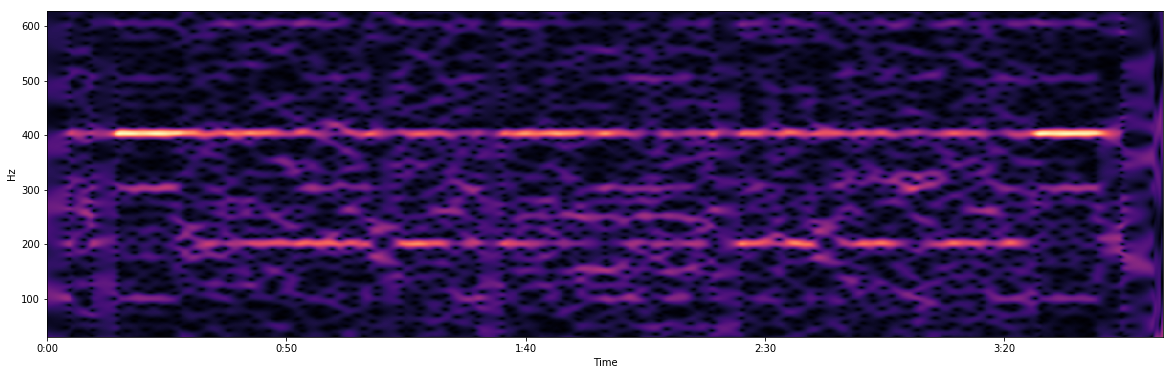

In [110]:
# Show tempogram
librosa.display.specshow(np.abs(tempogram.to_array()), x_axis='time', y_axis='linear', x_coords=t_np, y_coords=tempogram_y_axis.to_array()[:, 0])

In [111]:
# Cyclic tempogram
ref_tempo = 60
cyclic_tempogram, cyclic_tempogram_y_axis = lt.tempogram_to_cyclic_tempogram(tempogram, tempogram_y_axis, ref_tempo=ref_tempo)
cyclic_tempogram.get_shape()

(120, 1167)

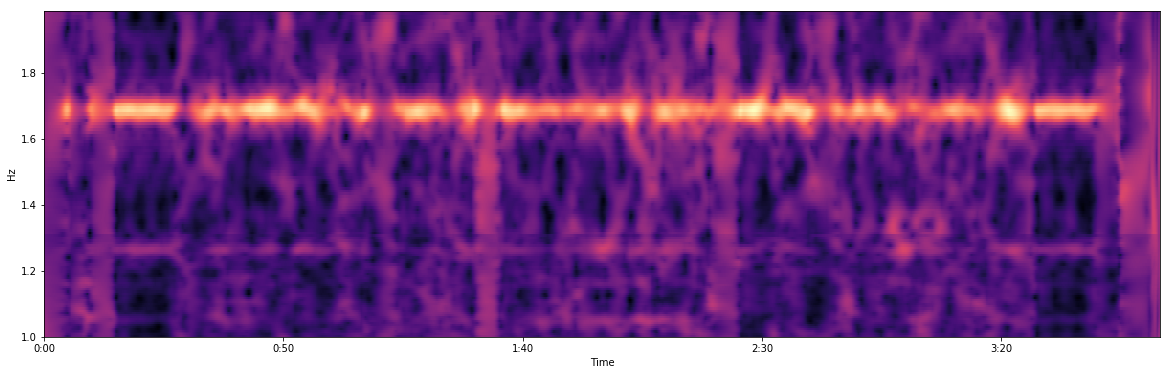

In [112]:
# Show cyclic tempogram
librosa.display.specshow(np.abs(cyclic_tempogram.to_array()), x_axis='time', y_axis='linear', x_coords=t_np, y_coords=cyclic_tempogram_y_axis.to_array()[:, 0])

In [113]:
# Smoothen tempogram
smooth_length = 20
smoothed_tempogram = lt.smoothen_tempogram(cyclic_tempogram, cyclic_tempogram_y_axis, t, smooth_length_samples)

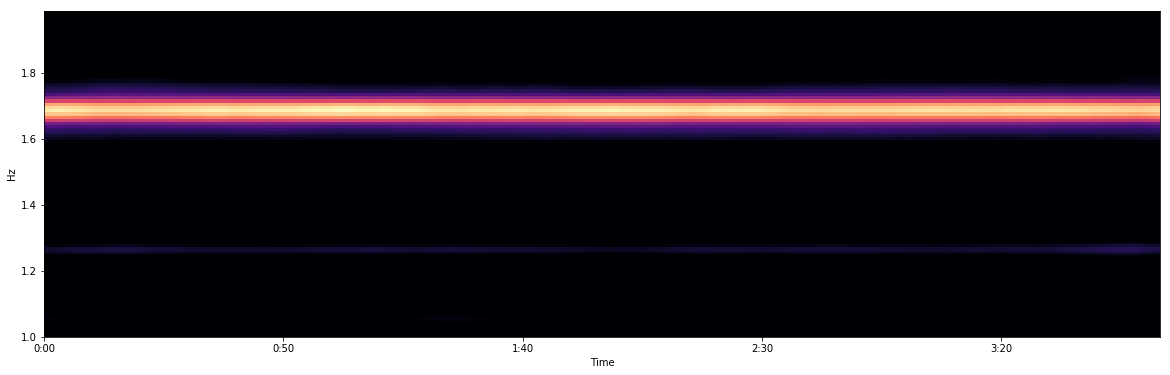

In [114]:
# Show smoothed tempogram
librosa.display.specshow(np.abs(smoothed_tempogram.to_array()), x_axis='time', y_axis='linear', x_coords=t_np, y_coords=cyclic_tempogram_y_axis.to_array()[:, 0])

In [115]:
# Tempo sections
tempo_curve = lt.tempogram_to_tempo_curve(smoothed_tempogram, cyclic_tempogram_y_axis)
tempo_curve = lt.correct_tempo_curve(tempo_curve, t, 5)
tempo_sections = lt.curve_to_sections(tempo_curve, t, ref_tempo, 100000, 1.5)
for s in tempo_sections: print(f'Time: {s.offset}, BPM: {s.bpm}')

Time: 0.0, BPM: 100.90756983044575


# Test a dataset item

In [116]:
candidate_section = tempo_sections[0]

In [117]:
section_start_idx = np.searchsorted(t_np, candidate_section.start)
section_end_idx = np.searchsorted(t_np, candidate_section.end)
print(f'{section_start_idx} to {section_end_idx}')

0 to 1166


In [118]:
tempogram_np = np.abs(tempogram.to_array())

In [119]:
tempo_distribution = np.sum(tempogram_np[:, section_start_idx:section_end_idx], axis=1)
tempo_distribution -= np.mean(tempo_distribution)
tempo_distribution[tempo_distribution < 0] = 0
tempo_distribution.shape

(600,)

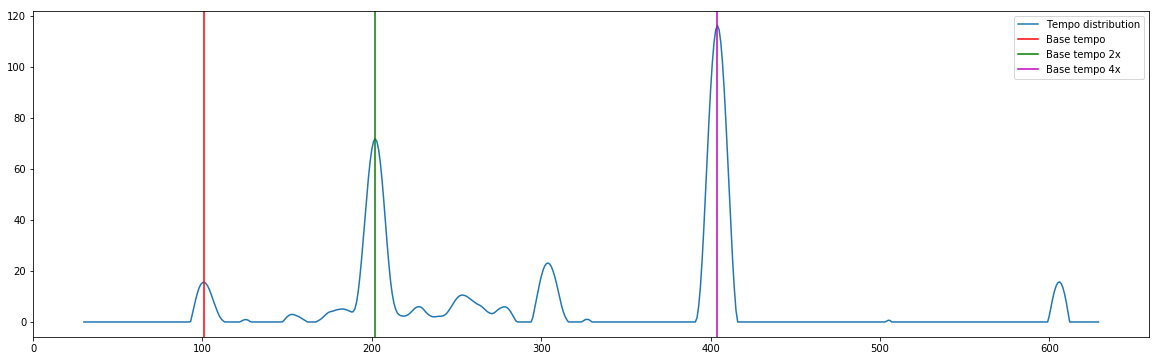

In [120]:
plt.plot(np.arange(start_tempo, end_tempo), tempo_distribution, label='Tempo distribution')
plt.axvline(x=candidate_section.bpm, label='Base tempo', color='r')
plt.axvline(x=candidate_section.bpm * 2, label='Base tempo 2x', color='g')
plt.axvline(x=candidate_section.bpm * 4, label='Base tempo 4x', color='m')
plt.legend()